# Detecting Covid-19 Chest X Ray Using Resnet50 Architechture.

# Importing Libraries

In [15]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt
from IPython.display import clear_output

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.7.0+cpu


# Preparing Training And Test Dataset

In [ ]:
class_names = ['Covid', 'Non-covid']  # we have two classes covid and non-covid
root_dir = 'Dataset2'
source_dirs = ['Covid', 'Non-Covid']  # these are dirs where the labels images are stored. Names are co-incidentally same with that of class names.

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if (x[-3:].lower().endswith('png') or x[-3:].lower().endswith('jpg') or x[-4:].lower().endswith('jpeg'))]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [16]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if (x[-3:].lower().endswith('png') or x[-3:].lower().endswith('jpg') or x[-4:].lower().endswith('jpeg')) ] 
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['Covid', 'Non-Covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformation

In [17]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [18]:
train_dirs = {
    'Covid': 'Dataset2/Covid',
    'Non-Covid' : 'Dataset2/Non-Covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1222 Covid examples
Found 1199 Non-Covid examples


In [19]:
test_dirs = {
    'Covid': 'Dataset2/test/Covid',
    'Non-Covid' : 'Dataset2/test/Non-Covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 Covid examples
Found 30 Non-Covid examples


In [20]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('Number of Training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of Training batches 404
Number of test batches 10


# Data Visualization

In [21]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(10, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green' 
        if preds[i] != labels[i]:
            col = 'red'
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

In [ ]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

In [ ]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [22]:
resnet50 = torchvision.models.resnet50(pretrained=True)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
resnet50.fc = torch.nn.Linear(in_features=2048, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=3e-5)

In [11]:
def show_preds():
    resnet50.eval() #We set the resnet18 model to evaluation mode.
    images, labels = next(iter(dl_test))
    outputs = resnet50(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

# Checkpoints to Save the Model

In [24]:
def save_checkpoint(model, optimizer, epoch, accuracy_yaxis, val_loss_yaxis, steps_xaxis):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'accuracy':accuracy_yaxis,
        'val_loss':val_loss_yaxis,
        'steps_xaxis':steps_xaxis
    }
    print(f'Progress Saved till epoch = {epoch}')
    torch.save(checkpoint, 'E:\\Image Recognition\\covid-chestxray-dataset\\resnet50_checkpoint.pth')

# Loading Saved Checkpoints

In [25]:
def load_checkpoint(model, optimizer):
    saved_checkpoint = torch.load('E:\\Image Recognition\\covid-chestxray-dataset\\resnet50_checkpoint.pth')
    model.load_state_dict(saved_checkpoint['model_state_dict'])
    optimizer.load_state_dict(saved_checkpoint['optimizer_state_dict'])
    epoch = saved_checkpoint['epoch']
    accuracy_yaxis = saved_checkpoint['accuracy']
    val_loss_yaxis = saved_checkpoint['val_loss']
    steps_xaxis = saved_checkpoint['steps_xaxis']
    return epoch, accuracy_yaxis, val_loss_yaxis, steps_xaxis

# Training the Model

In [29]:
def train(epochs, resume_from_checkpoint = False):

    accuracy_yaxis = []
    val_loss_yaxis = []
    train_loss_yaxis = []
    val_accuracy_yaxis = []
    steps_xaxis = []

    if resume_from_checkpoint == True:
        starting_epoch, accuracy_yaxis, val_loss_yaxis, steps_xaxis = load_checkpoint(resnet50, optimizer)
        print('Starting Epoch = ', starting_epoch)
        print('Resumed from Last Saved Checkpoint')
    else:
        starting_epoch = 0

    print('Starting Training ...')
    
    for e in range(starting_epoch, starting_epoch + epochs):
        print('_'*20)
        print(f'Starting epoch {e + 1} / {starting_epoch + epochs}')
        print('_'*20)

        train_loss, val_loss = 0, 0
        resnet50.train() #we put the resnet model to train mode.

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad() #Before training our gradient is always zero.
            outputs = resnet50(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                accuracy = 0
                resnet50.eval() #We put the resnet18 model to evaluation mode.

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet50(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_accuracy_yaxis.append(accuracy)
                train_loss_yaxis.append(train_loss)
                val_loss /= (val_step + 1)
                accuracy = accuracy / len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy:{accuracy:.4f}')
                accuracy_yaxis.append(accuracy)
                val_loss_yaxis.append(val_loss)
                steps_xaxis.append(((len(dl_train) - 1) * e) + train_step)
                #show_preds()
                resnet50.train()

                if accuracy >= 0.99:
                    print('Performance Condition Satisfied, Stopping ...')
                    return (accuracy_yaxis, val_loss_yaxis, train_loss_yaxis, val_accuracy_yaxis, steps_xaxis)

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')

        if (e + 1) % 5 == 0:
            save_checkpoint(resnet50, optimizer, e + 1, accuracy_yaxis, val_loss_yaxis, steps_xaxis)
    
    print('Training Complete ....')
    return (accuracy_yaxis, val_loss_yaxis, train_loss_yaxis, val_accuracy_yaxis, steps_xaxis)


In [30]:
%%time
accuracy_yaxis, val_loss_yaxis, train_loss_yaxis, val_accuracy_yaxis, steps_xaxis = train(epochs = 2)

Starting Training ...
____________________
Starting epoch 1 / 2
____________________
Evaluating at step 0
Validation Loss: 0.1223, Accuracy:0.9833
Evaluating at step 20
Validation Loss: 0.2418, Accuracy:0.9000
Evaluating at step 40
Validation Loss: 0.1532, Accuracy:0.9667
Evaluating at step 60
Validation Loss: 0.1945, Accuracy:0.9167
Evaluating at step 80
Validation Loss: 0.1264, Accuracy:0.9667
Evaluating at step 100
Validation Loss: 0.2128, Accuracy:0.9167
Evaluating at step 120
Validation Loss: 0.2532, Accuracy:0.8833
Evaluating at step 140
Validation Loss: 0.3465, Accuracy:0.9000
Evaluating at step 160
Validation Loss: 0.2238, Accuracy:0.9167
Evaluating at step 180
Validation Loss: 0.1398, Accuracy:0.9333
Evaluating at step 200
Validation Loss: 0.1897, Accuracy:0.9000
Evaluating at step 220
Validation Loss: 0.2291, Accuracy:0.9500
Evaluating at step 240
Validation Loss: 0.1960, Accuracy:0.9500
Evaluating at step 260
Validation Loss: 0.0972, Accuracy:0.9667
Evaluating at step 280
Va

# Final Results

In [ ]:
show_preds()

# Plotting the Results

Text(0.5, 1.0, '(Validation Loss , Accuracy) VS Train Step')

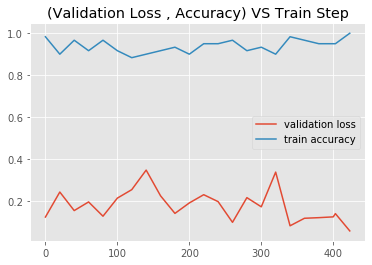

In [31]:
plt.style.use("ggplot")
plt.figure()
plt.plot(steps_xaxis, val_loss_yaxis, label = 'validation loss')
plt.plot(steps_xaxis, accuracy_yaxis, label = 'train accuracy')
#plt.plot(steps_xaxis, train_loss_yaxis, label = 'train loss')
#plt.plot(steps_xaxis, val_accuracy_yaxis, label = 'validation accuracy')
plt.legend()
plt.title('(Validation Loss , Accuracy) VS Train Step')